In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install transformers
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path="/content/drive/My Drive"
df = pd.read_csv(data_path+"/train.csv")
df.head()

Mounted at /content/drive


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [ ]:
df['list'] = df[df.columns[2:]].values.tolist()
new_df = df[['comment_text', 'list']].copy()
new_df.head()

,comment_text,list
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


# Are Toxic Comments Shorter or Longer?

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
df['word_count'] = df['comment_text'].apply(lambda x: len(word_tokenize(x)))

In [ ]:
# Melt the DataFrame to have toxicity types as a single column
df_melted = df.melt(id_vars=['comment_text', 'word_count'],
                    value_vars=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                    var_name='toxicity_type', value_name='is_toxic')

In [ ]:
# Calculate average word count for each toxicity type
avg_len_by_class = df_melted[df_melted['is_toxic'] == 1].groupby('toxicity_type')['word_count'].mean().reset_index()

In [ ]:
# Calculate average word count for non-toxic comments
non_toxic_comments = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]
avg_len_non_toxic = non_toxic_comments['word_count'].mean()

In [ ]:
# Create a DataFrame for non-toxic comments
avg_len_non_toxic_df = pd.DataFrame({'toxicity_type': ['non_toxic'], 'word_count': [avg_len_non_toxic]})


In [ ]:
# Combine the results
avg_lengths = pd.concat([avg_len_by_class, avg_len_non_toxic_df])

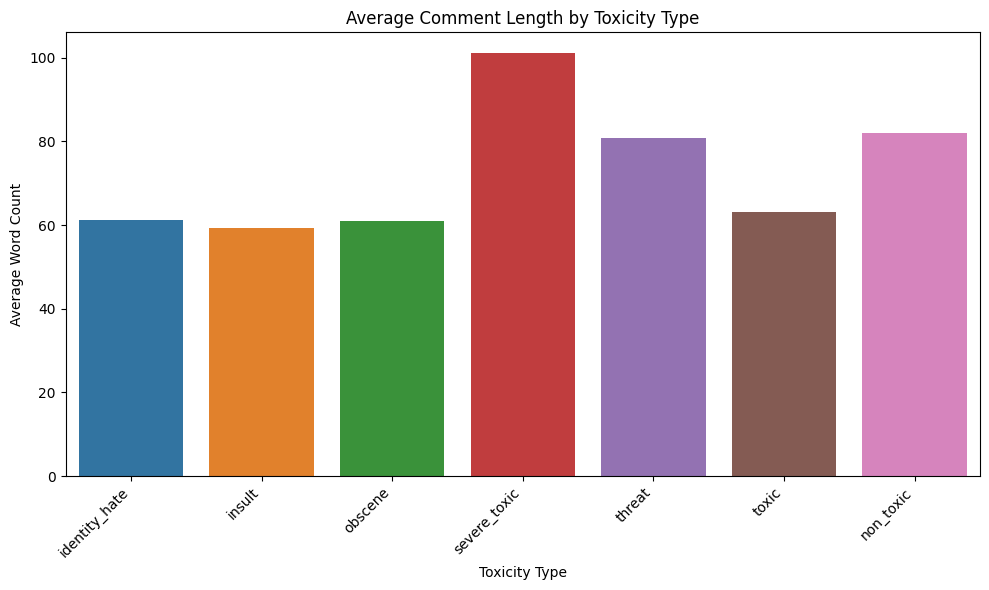

In [ ]:
# Visualize the average lengths

plt.figure(figsize=(10, 6))
sns.barplot(x='toxicity_type', y='word_count', hue='toxicity_type', data=avg_lengths)
plt.title('Average Comment Length by Toxicity Type')
plt.xlabel('Toxicity Type')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# What Are The Most Common Words in Toxic Comments?

In [ ]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

# Tokenize and remove stopwords
tokens = df[df.toxic == 1]['comment_text'].apply(word_tokenize)
all_tokens = [word.lower() for sublist in tokens for word in sublist if word.isalpha() and word.lower() not in stop_words]

In [ ]:
def replace_vowels(word):
    vowels = "aeiouAEIOU"
    new_word = ""
    word = word.lower()
    forbidden_words = ["fuck", "shit", "fucking", "nigger"]
    if word in forbidden_words:
      for char in word:
          if char in vowels:
              new_word += "*"
          else:
              new_word += char
      return new_word
    else:
      return word

In [ ]:
fdist = FreqDist(all_tokens)
fdist_5_most_common = fdist.most_common(5)
reworded_fdist_5_most_common = [(replace_vowels(word), count) for word, count in fdist_5_most_common]
reworded_fdist_5_most_common

[('f*ck', 9238),
 ('sh*t', 3580),
 ('like', 3485),
 ('wikipedia', 3385),
 ('n*gg*r', 3290)]

In [ ]:
# Create a DataFrame from the reworded most common words
reworded_df = pd.DataFrame(reworded_fdist_5_most_common, columns=['word', 'count'])

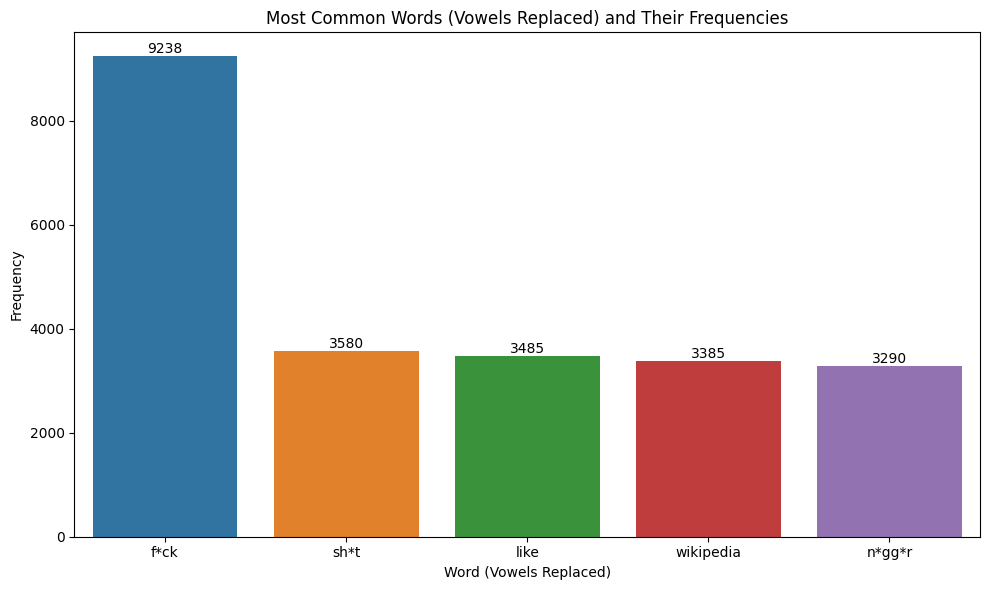

In [ ]:
# Visualize the reworded most common words
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='word', y='count', hue='word', data=reworded_df)
plt.title('Most Common Words (Vowels Replaced) and Their Frequencies')
plt.xlabel('Word (Vowels Replaced)')
plt.ylabel('Frequency')

# Annotate the bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

# Common Hate Phrases or Slurs

In [ ]:
from nltk import ngrams
from collections import Counter

In [ ]:
tokens = df[df.toxic == 1]['comment_text'].apply(word_tokenize)
bigrams = [ngram for comment in tokens for ngram in ngrams(comment, 2)]
most_common_phrases = Counter(bigrams).most_common(20)

In [ ]:
reworded_most_common_phrases = []
for bigram, count in most_common_phrases:
    reworded_bigram = (replace_vowels(bigram[0]), replace_vowels(bigram[1]))
    reworded_most_common_phrases.append((reworded_bigram, count))

reworded_most_common_phrases

[(('!', '!'), 38373),
 (('.', 'i'), 4046),
 (("''", "''"), 3671),
 (('``', "''"), 3065),
 (('is', 'a'), 2490),
 ((',', 'i'), 2399),
 (('.', 'you'), 2268),
 ((',', 'you'), 2127),
 ((',', 'and'), 2069),
 (('do', "n't"), 1920),
 (('n*gg*r', 'n*gg*r'), 1882),
 (('you', 'are'), 1789),
 (('?', '?'), 1673),
 (('i', 'am'), 1610),
 (('f*ck', 'you'), 1570),
 (('moron', 'hi'), 1474),
 (('hi', 'moron'), 1472),
 (('of', 'the'), 1386),
 (('i', "'m"), 1265),
 (('pig', 'pig'), 1249)]

<ipython-input-25-9f0ddf522b39>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='bigram_str', y='count', data=df_bigrams, palette='viridis')


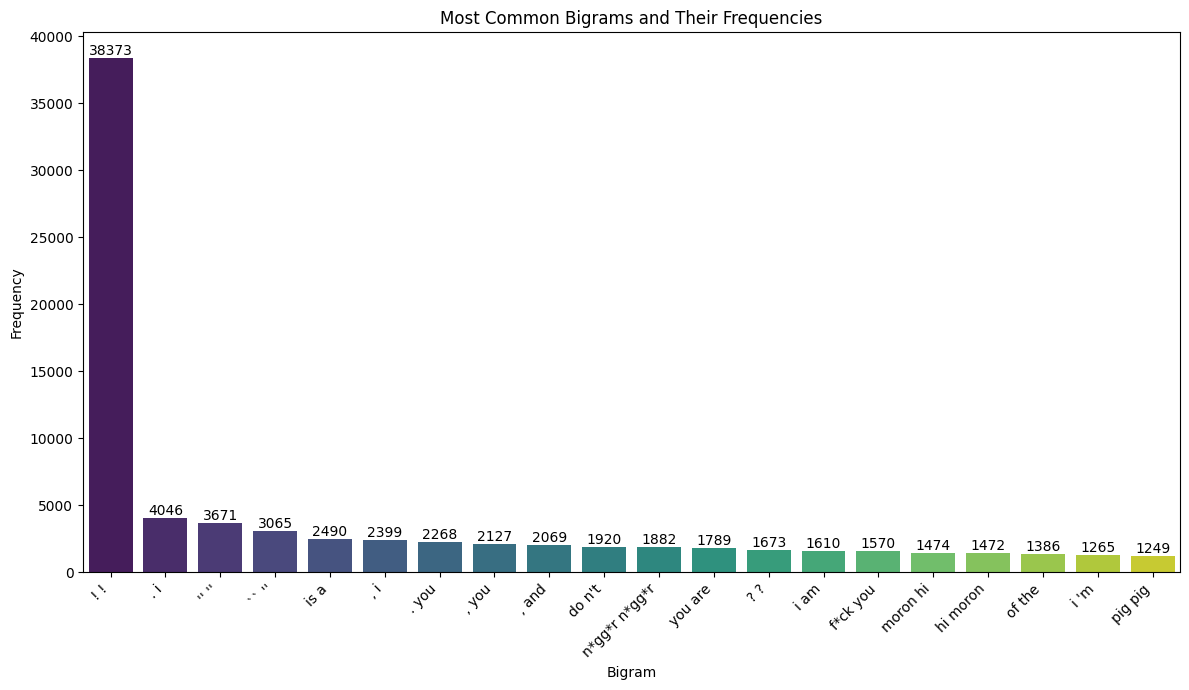

In [ ]:
# Create a DataFrame
df_bigrams = pd.DataFrame(reworded_most_common_phrases, columns=['bigram', 'count'])

# Format the bigrams as strings
df_bigrams['bigram_str'] = df_bigrams['bigram'].apply(lambda x: ' '.join(x))

# Visualize the most common bigrams
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='bigram_str', y='count', data=df_bigrams, palette='viridis')
plt.title('Most Common Bigrams and Their Frequencies')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

# Are Toxic Comments More Likely To Use Certain Tags?

In [ ]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Define the toxicity label columns
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Filter for toxic comments
# A comment is considered toxic if at least one of the label columns is 1
toxic_df = df[df[label_columns].sum(axis=1) > 0].copy()

# Apply POS tagging to toxic comments
toxic_df['pos_tags'] = toxic_df['comment_text'].apply(lambda x: pos_tag(word_tokenize(x)))

In [ ]:
print(toxic_df.shape)

(16225, 11)


In [ ]:
# Extract all POS tags from the DataFrame column
all_pos_tags = [tag for sublist in toxic_df['pos_tags'] for word, tag in sublist]

# Count the frequency of each POS tag using FreqDist
pos_tag_freqdist = FreqDist(all_pos_tags)

In [ ]:
most_common_pos_tag = pos_tag_freqdist.most_common(10)

In [ ]:
most_common_pos_tag

[('NNP', 158934),
 ('NN', 122885),
 ('.', 104095),
 ('PRP', 76086),
 ('IN', 66854),
 ('DT', 61099),
 ('JJ', 57963),
 ('VBP', 48339),
 ('RB', 42894),
 ('VB', 40794)]

<ipython-input-32-7fdf237947a8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='POS_tag', y='frequency', data=df_pos, palette='viridis')


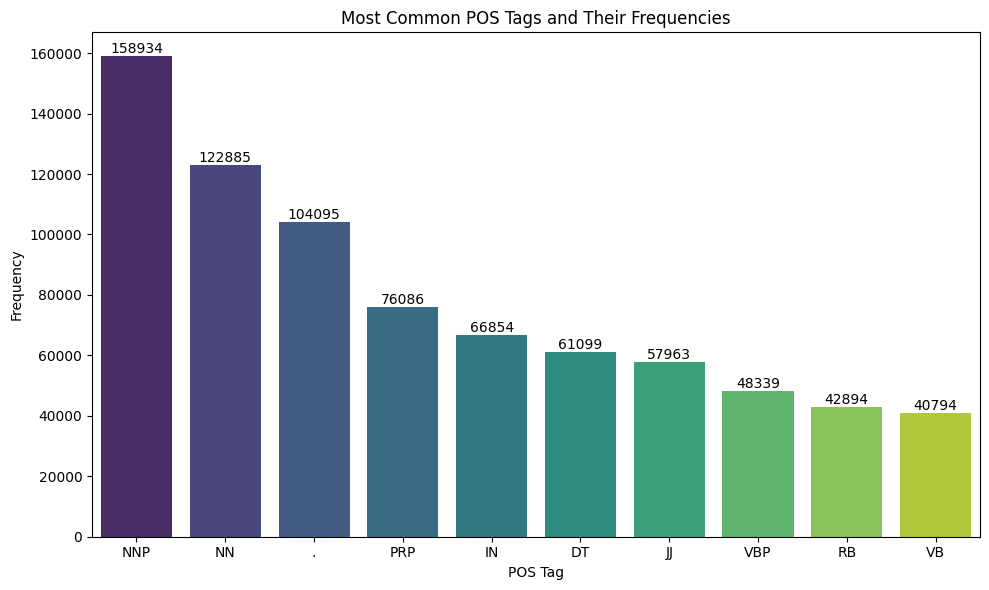

In [ ]:
# Create a DataFrame
df_pos = pd.DataFrame(most_common_pos_tag, columns=['POS_tag', 'frequency'])

# Visualize the POS tag frequencies
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='POS_tag', y='frequency', data=df_pos, palette='viridis')

# Add labels and title
plt.title('Most Common POS Tags and Their Frequencies')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

# Lexical Diversity

In [ ]:
df['lexical_diversity'] = df['comment_text'].apply(lambda x: len(set(word_tokenize(x))) / len(word_tokenize(x)))


In [ ]:
df['lexical_diversity']

,lexical_diversity
0,0.897959
1,0.851852
2,0.895833
3,0.703125
4,0.944444
...,...
159566,0.761905
159567,1.000000
159568,0.933333
159569,0.884615


In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'list', 'word_count', 'lexical_diversity'],
      dtype='object')

In [ ]:
# Define the toxicity label columns
label_columns = ['severe_toxic', 'threat', 'obscene', 'insult', 'identity_hate', 'toxic']

# Initialize the 'primary_toxicity_type' column with 'non_toxic'
df['primary_toxicity_type'] = 'non_toxic'

# Iterate through the label columns and assign the label
# We iterate in reverse order of priority so that higher priority labels
# overwrite lower priority labels if a comment belongs to multiple categories
for col in reversed(label_columns):
    df.loc[df[col] == 1, 'primary_toxicity_type'] = col

In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'list', 'word_count', 'lexical_diversity',
       'primary_toxicity_type'],
      dtype='object')

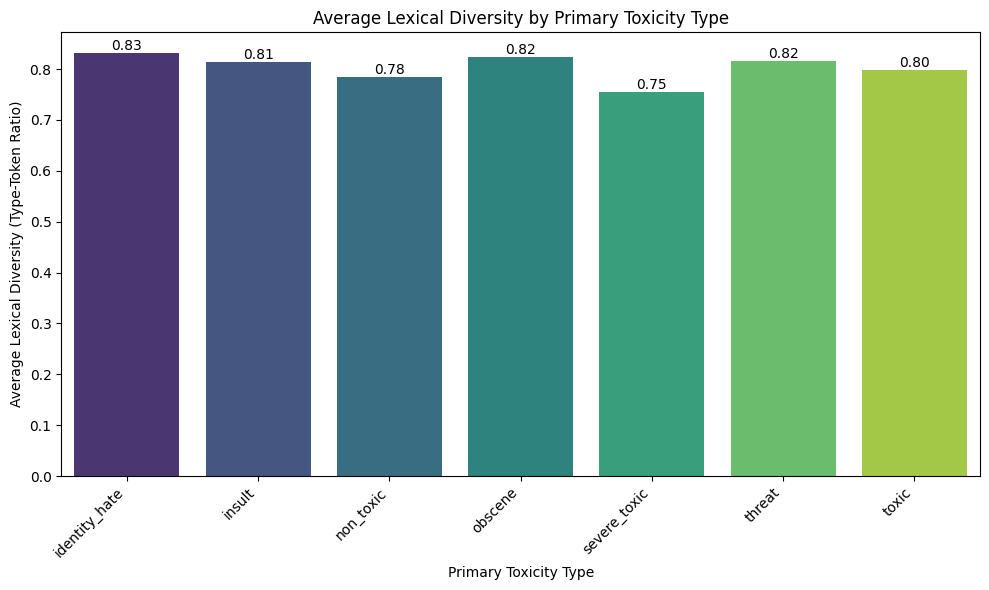

In [ ]:
# Calculate average lexical diversity for each toxicity type
avg_diversity_by_type = df.groupby('primary_toxicity_type')['lexical_diversity'].mean().reset_index()

# Visualize the average lexical diversity
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='primary_toxicity_type', y='lexical_diversity', hue='primary_toxicity_type', data=avg_diversity_by_type, palette='viridis')

plt.title('Average Lexical Diversity by Primary Toxicity Type')
plt.xlabel('Primary Toxicity Type')
plt.ylabel('Average Lexical Diversity (Type-Token Ratio)')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

# Class Distribution

In [ ]:
class_counts = df[label_columns].sum()

In [ ]:
class_counts

,0
severe_toxic,1595
threat,478
obscene,8449
insult,7877
identity_hate,1405
toxic,15294


In [ ]:
class_percent = (class_counts / class_counts.sum()) * 100

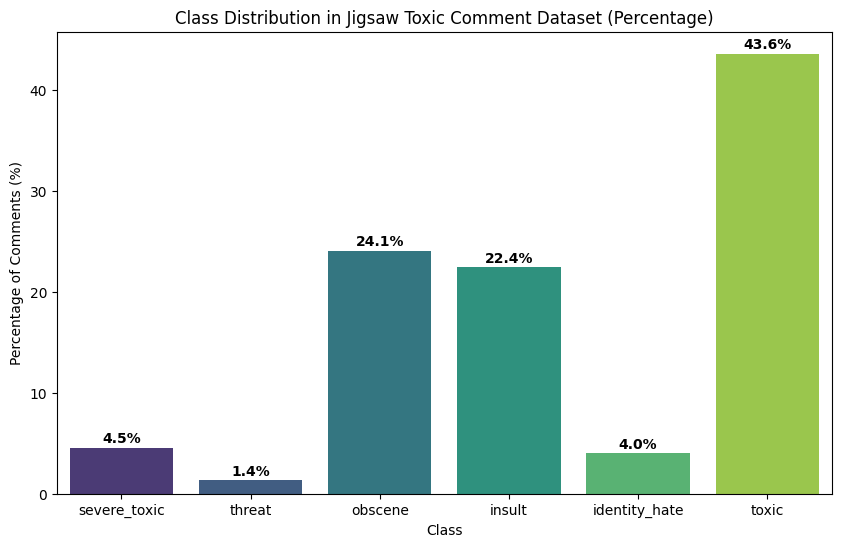

In [ ]:
# Plot class distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=class_percent.index, y=class_percent.values, hue=class_percent.index, palette='viridis')

# Add percentage labels
for i, v in enumerate(class_percent.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.title('Class Distribution in Jigsaw Toxic Comment Dataset (Percentage)')
plt.ylabel('Percentage of Comments (%)')
plt.xlabel('Class')
plt.show()

In [ ]:
df['num_labels'] = df[label_columns].sum(axis=1)

In [ ]:
# Compute counts
label_counts = df['num_labels'].value_counts().sort_index()

# Convert counts to percentage
label_percent = (label_counts / label_counts.sum()) * 100

In [ ]:
percent_df = label_percent.reset_index()
percent_df.columns = ['num_labels', 'percentage']

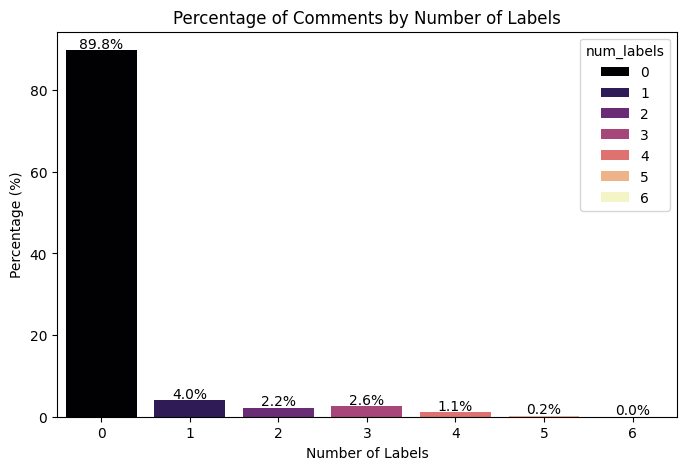

In [ ]:
# Plot percentage distribution
plt.figure(figsize=(8, 5))
sns.barplot(x='num_labels', y='percentage', hue='num_labels', data=percent_df, palette='magma')

plt.title('Percentage of Comments by Number of Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Percentage (%)')

# Show exact percentage on top of each bar
for index, row in percent_df.iterrows():
    plt.text(x=index, y=row['percentage'] + 0.5, s=f"{row['percentage']:.1f}%", ha='center')

plt.show()

# Embeddings using gloVE

In [ ]:
glove_file_path = '/content/drive/My Drive/glove.6B.100d.txt'

In [ ]:
# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [ ]:
label_columns = ['severe_toxic', 'threat', 'obscene', 'insult', 'identity_hate', 'toxic']

In [ ]:
toxic_df_emb = df[df[label_columns].sum(axis=1) > 0].copy()

In [ ]:
toxic_only_df = df[df['toxic'] == 1].copy()

In [ ]:
# Generate a comment embedding by averaging word embeddings
def create_comment_embedding(comment, embeddings_index, embedding_dim):
        tokens = word_tokenize(comment.lower())
        # Filter out non-alphabetic tokens
        cleaned_tokens = [word for word in tokens if word.isalpha()]
        valid_embeddings = [embeddings_index[word] for word in cleaned_tokens if word in embeddings_index]

        if not valid_embeddings:
            return np.zeros(embedding_dim)

        return np.mean(valid_embeddings, axis=0)

In [ ]:
embedding_dim = 100

In [ ]:
toxic_only_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
toxic_only_df['label'] = toxic_only_df.apply(assign_label, axis=1)

In [ ]:
# Generate embeddings for all comments
comment_embeddings = np.array([create_comment_embedding(comment, embeddings_index, embedding_dim) for comment in toxic_only_df['comment_text']])

print(f'Shape of comment embeddings: {comment_embeddings.shape}')


Shape of comment embeddings: (15294, 100)


# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(comment_embeddings)

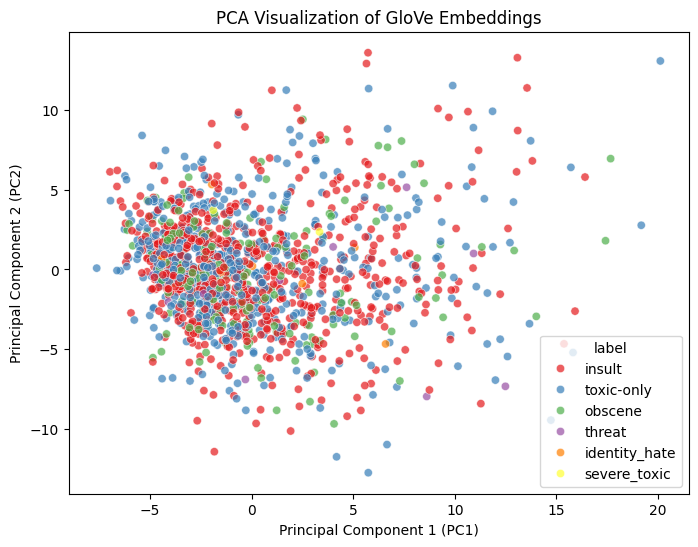

In [ ]:
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_embeddings)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['label'] = toxic_only_df['label']

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='Set1', alpha=0.7)
plt.title('PCA Visualization of GloVe Embeddings')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

#  UMAP Visualization

In [ ]:
!pip install umap-learn

In [ ]:
label_columns

['severe_toxic', 'threat', 'obscene', 'insult', 'identity_hate', 'toxic']

In [ ]:
import umap

In [ ]:
toxic_only_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'list', 'word_count', 'lexical_diversity',
       'primary_toxicity_type', 'num_labels'],
      dtype='object')

In [ ]:
# Initialize UMAP
# n_components=2 for 2D visualization
# random_state for reproducibility
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.4, metric='cosine')

# Fit and transform the embeddings
# This will also perform dimensionality reduction
embedding_2d = reducer.fit_transform(comment_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
subtypes = ['insult', 'obscene', 'threat', 'identity_hate', 'severe_toxic']

def assign_label(row):
    for subtype in subtypes:
        if row[subtype] == 1:
            return subtype
    return 'toxic-only'  # fallback label if only 'toxic' is marked

In [ ]:
toxic_only_df['label'] = toxic_only_df.apply(assign_label, axis=1)

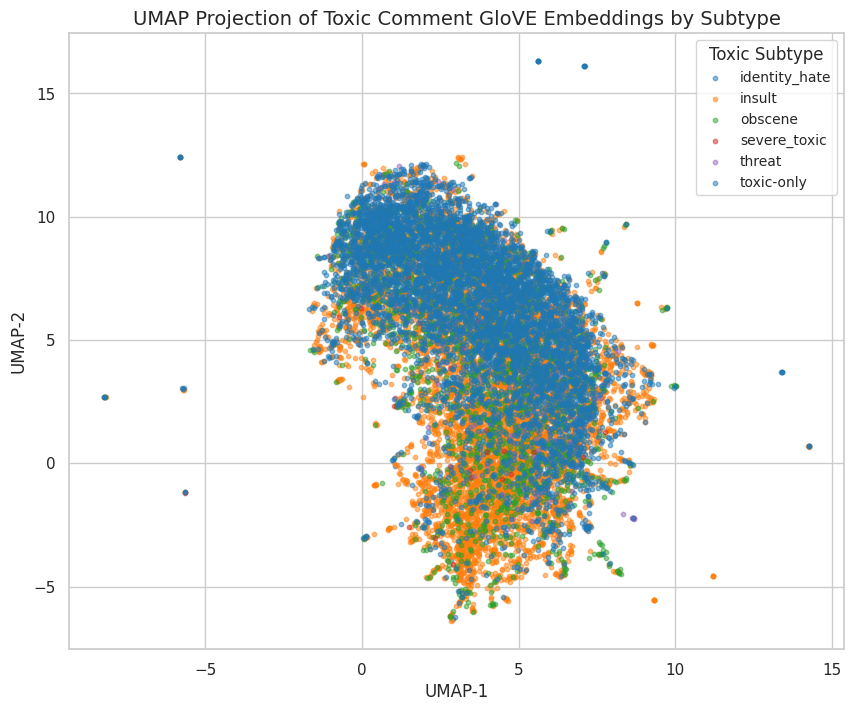

In [ ]:
sns.set(style="whitegrid")

# Map labels to colors
labels = toxic_only_df['label'].tolist()
unique_labels = sorted(set(labels))
default_palette = sns.color_palette("tab10", len(unique_labels))
label_colors = {}

for i, label in enumerate(unique_labels):
    if label == "toxic-only":
        label_colors[label] = '#1f77b4'  # matplotlib's default blue
    else:
        label_colors[label] = default_palette[i]

# Plot
plt.figure(figsize=(10, 8))

for label in unique_labels:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1],
                label=label, color=label_colors[label], s=10, alpha=0.5)
plt.legend(title="Toxic Subtype", fontsize=10)
plt.title("UMAP Projection of Toxic Comment GloVE Embeddings by Subtype", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# Sentence Embeddings

In [ ]:
toxic_df = df[df['toxic'] == 1].copy()

In [ ]:
toxic_df.shape

(15294, 8)

In [ ]:
texts = toxic_df['comment_text'].tolist()

In [ ]:
subtypes = ['insult', 'obscene', 'threat', 'identity_hate', 'severe_toxic']

def assign_label(row):
    for subtype in subtypes:
        if row[subtype] == 1:
            return subtype
    return 'toxic-only'  # fallback label if only 'toxic' is marked

In [ ]:
toxic_df['label'] = toxic_df.apply(assign_label, axis=1)

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [ ]:
# Generate sentence embeddings
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True, device=device)

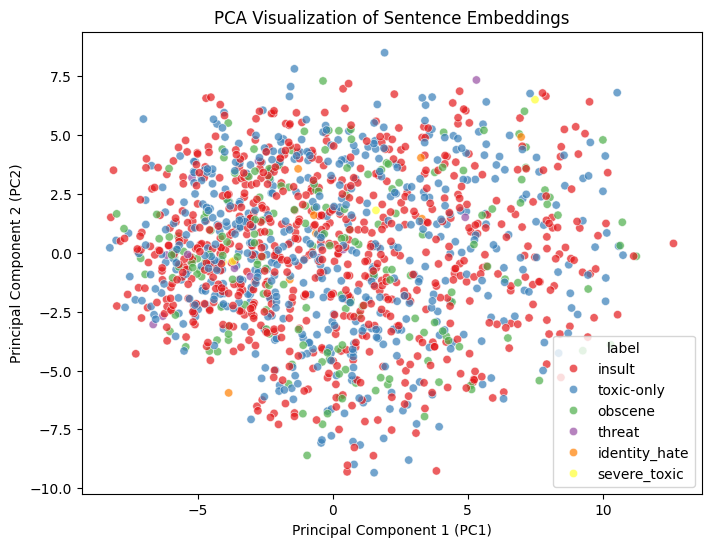

In [ ]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_embeddings)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['label'] = toxic_only_df['label']

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='Set1', alpha=0.7)
plt.title('PCA Visualization of Sentence Embeddings')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

In [ ]:
# adds noise
embeddings += 1e-5 * np.random.randn(*embeddings.shape)

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.4, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


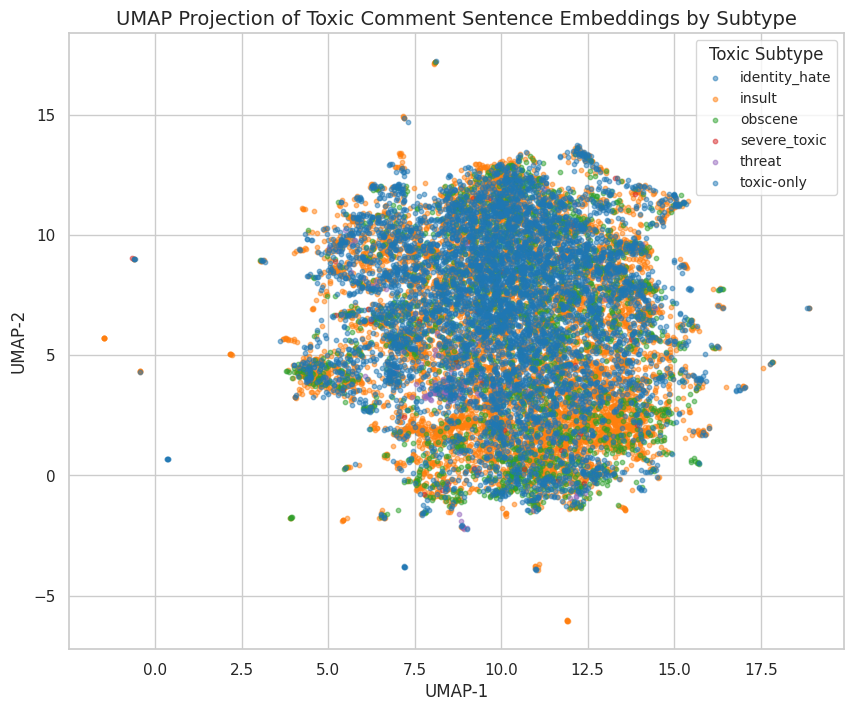

In [ ]:
sns.set(style="whitegrid")

# Map labels to colors
labels = toxic_df['label'].tolist()
unique_labels = sorted(set(labels))
default_palette = sns.color_palette("tab10", len(unique_labels))
label_colors = {}

for i, label in enumerate(unique_labels):
    if label == "toxic-only":
        label_colors[label] = '#1f77b4'  # matplotlib's default blue
    else:
        label_colors[label] = default_palette[i]

# Plot
plt.figure(figsize=(10, 8))

for label in unique_labels:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1],
                label=label, color=label_colors[label], s=10, alpha=0.5)
plt.legend(title="Toxic Subtype", fontsize=10)
plt.title("UMAP Projection of Toxic Comment Sentence Embeddings by Subtype", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()